In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('course_lead_scoring.csv')
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [3]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [4]:
for col in df.columns:
     if df[col].dtype == 'object':
         df[col] = df[col].fillna('NA')
     else:
         df[col] = df[col].fillna(0.0)

In [5]:
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NA,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NA,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [6]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
len(df_train), len(df_val), len(df_test)

(876, 293, 293)

In [7]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [8]:
y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

del df_train['converted']
del df_val['converted']
del df_test['converted']

In [9]:
# Identify feature types
categorical_features = ['lead_source', 'industry', 'employment_status', 'location']
numerical_features = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']
target = 'converted'

In [10]:
from sklearn.metrics import roc_auc_score

In [11]:
# Question 1
auc_scores = {}
for col in numerical_features:
    # Use the numerical variable as the score (prediction)
    y_pred = df_train[col].values
    
    # Compute AUC
    auc = roc_auc_score(y_train, y_pred)
    
    # Invert the score if AUC is < 0.5
    if auc < 0.5:
        y_pred = -y_pred
        auc = roc_auc_score(y_train, y_pred)
    
    auc_scores[col] = auc


for feature, auc in auc_scores.items():
    print(f"Feature '{feature}': AUC = {auc:.4f}")

Feature 'number_of_courses_viewed': AUC = 0.7636
Feature 'annual_income': AUC = 0.5520
Feature 'interaction_count': AUC = 0.7383
Feature 'lead_score': AUC = 0.6145


In [12]:
# Which variable has the highest AUC
best_auc_feature = max(auc_scores, key=auc_scores.get)
print(f"Highest AUC: {auc_scores[best_auc_feature]:.4f}, by feature: '{best_auc_feature}'")

Highest AUC: 0.7636, by feature: 'number_of_courses_viewed'


In [13]:
# Question 2
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [17]:
# Prepare the data for DictVectorizer (all features)
numerical_features_q2 = ['number_of_courses_viewed', 'annual_income', 'interaction_count']
categorical_features_q2 = ['lead_source', 'industry', 'employment_status', 'location']
all_features_q2 = numerical_features_q2 + categorical_features_q2

# Convert DataFrames to a list of dictionaries
train_dicts = df_train[all_features_q2].to_dict(orient='records')
val_dicts = df_val[all_features_q2].to_dict(orient='records')

# Apply One-Hot Encoding
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

# Train the Logistic Regression model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=1)
model.fit(X_train, y_train)

# Predict probabilities on the validation set
y_pred_val_proba = model.predict_proba(X_val)[:, 1]

# Compute AUC on the validation set
auc_val = roc_auc_score(y_val, y_pred_val_proba)
print(f"\nQuestion 2: AUC on validation set: {auc_val:.3f}")


Question 2: AUC on validation set: 0.816


In [24]:
# Question 3
import matplotlib.pyplot as plt
import numpy as np

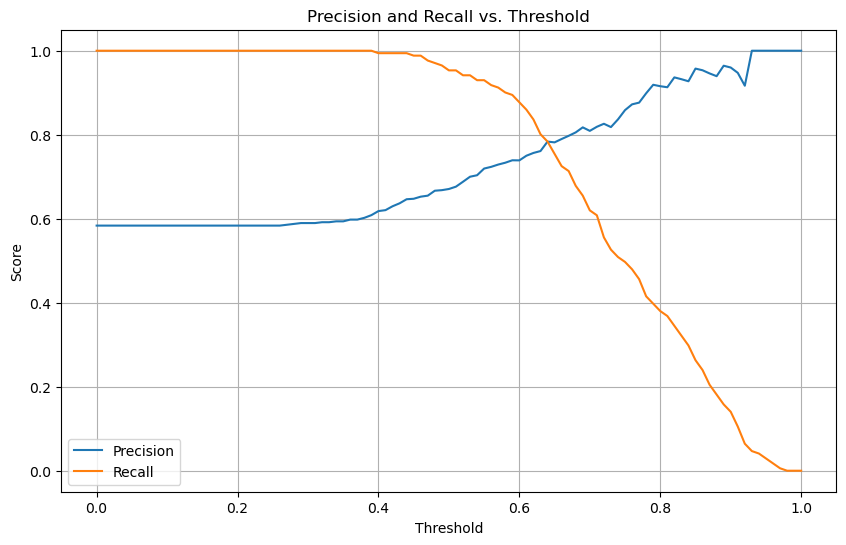

Threshold where precision and recall curves intersect (closest point): 0.640


In [26]:
# Compute precision and recall for a given threshold
def confusion_matrix_at_threshold(y_true, y_pred_proba, threshold):
    # Convert probabilities to binary predictions
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    # True Positives, False Positives, False Negatives
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    
    # Precision and Recall
    precision = tp / (tp + fp) if (tp + fp) > 0 else 1.0 # Handle division by zero
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0     # Handle division by zero
    
    return precision, recall, tp, fp, fn

# Compute Precision and Recall for all thresholds from 0.0 to 1.0 with step 0.01
thresholds = np.arange(0.0, 1.01, 0.01)
scores = []

for t in thresholds:
    p, r, tp, fp, fn = confusion_matrix_at_threshold(y_val, y_pred_val_proba, t)
    scores.append((t, p, r))

# Convert to DataFrame for easier handling
df_scores = pd.DataFrame(scores, columns=['threshold', 'precision', 'recall'])

# Visual Confirmation
plt.figure(figsize=(10, 6))
plt.plot(df_scores.threshold, df_scores.precision, label='Precision')
plt.plot(df_scores.threshold, df_scores.recall, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()

# Find the intersection point
df_scores['diff'] = np.abs(df_scores['precision'] - df_scores['recall'])
intersection_threshold = df_scores.loc[df_scores['diff'].idxmin(), 'threshold']
print(f"Threshold where precision and recall curves intersect (closest point): {intersection_threshold:.3f}")

In [27]:
# Question 4
df_scores['f1'] = 2 * (df_scores['precision'] * df_scores['recall']) / (df_scores['precision'] + df_scores['recall'])
df_scores['f1'] = df_scores['f1'].fillna(0.0)

# Find the threshold with maximal F1 score
maximal_f1_score = df_scores['f1'].max()
f1_maximal_threshold = df_scores.loc[df_scores['f1'].idxmax(), 'threshold']
print(f"Maximal F1 score: {maximal_f1_score:.3f} at threshold: {f1_maximal_threshold:.2f}")

Maximal F1 score: 0.811 at threshold: 0.55


In [33]:
# Question 5
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

In [34]:
# Train and evaluate the model using cross-validation
def train_and_evaluate_cv(df_full_train, y_full_train, C_value, n_splits=5, random_state=1):
    
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    auc_scores_cv = []
    
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train_fold = df_full_train.iloc[train_idx]
        y_train_fold = y_full_train[train_idx]
        
        df_val_fold = df_full_train.iloc[val_idx]
        y_val_fold = y_full_train[val_idx]
        
        # Prepare data for DictVectorizer (all features except 'lead_score')
        train_dicts_fold = df_train_fold[all_features_q2].to_dict(orient='records')
        val_dicts_fold = df_val_fold[all_features_q2].to_dict(orient='records')
        
        dv_cv = DictVectorizer(sparse=False)
        X_train_fold = dv_cv.fit_transform(train_dicts_fold)
        X_val_fold = dv_cv.transform(val_dicts_fold)
        
        # Train the Logistic Regression model
        model_cv = LogisticRegression(solver='liblinear', C=C_value, max_iter=1000, random_state=1)
        model_cv.fit(X_train_fold, y_train_fold)
        
        # Predict probabilities on the validation set
        y_pred_val_proba_cv = model_cv.predict_proba(X_val_fold)[:, 1]
        
        # Compute AUC on the validation set
        auc_cv = roc_auc_score(y_val_fold, y_pred_val_proba_cv)
        auc_scores_cv.append(auc_cv)
        
    return auc_scores_cv

# Perform 5-Fold CV with C=1.0
C_q5 = 1.0
auc_scores_q5 = train_and_evaluate_cv(df_full_train, y_full_train, C_q5)

std_auc_q5 = np.std(auc_scores_q5)
print(f"AUC scores for C={C_q5}: {auc_scores_q5}")
print(f"Standard deviation of AUC scores: {std_auc_q5:.4f}")

AUC scores for C=1.0: [0.8054046006104371, 0.8703573383376338, 0.7737117835640004, 0.8024595267745952, 0.8551307847082494]
Standard deviation of AUC scores: 0.0358


In [32]:
# Question 6

C_values = [0.000001, 0.001, 1]
results_q6 = []

for C in C_values:
    auc_scores_q6 = train_and_evaluate_cv(df_full_train, y_full_train, C)
    mean_auc = np.mean(auc_scores_q6)
    std_auc = np.std(auc_scores_q6)
    results_q6.append((C, mean_auc, std_auc))

# Convert to DataFrame for easier sorting and analysis
df_results_q6 = pd.DataFrame(results_q6, columns=['C', 'mean_auc', 'std_auc'])

# Sort for best mean_auc, then lowest std_auc, then smallest C
df_results_q6['mean_auc_round'] = df_results_q6['mean_auc'].round(3)
df_results_q6['std_auc_round'] = df_results_q6['std_auc'].round(3)

# Sort by mean_auc (desc), std_auc (asc), C (asc)
best_c_result = df_results_q6.sort_values(by=['mean_auc', 'std_auc', 'C'], ascending=[False, True, True]).iloc[0]

print("Hyperparameter Tuning Results:")
print(df_results_q6[['C', 'mean_auc_round', 'std_auc_round']])
print(f"Best C: {best_c_result['C']} with mean AUC {best_c_result['mean_auc_round']} and std {best_c_result['std_auc_round']}")

Hyperparameter Tuning Results:
          C  mean_auc_round  std_auc_round
0  0.000001           0.560          0.024
1  0.001000           0.865          0.029
2  1.000000           0.821          0.036
Best C: 0.001 with mean AUC 0.865 and std 0.029
